In [3]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

## 1. Image Preprocessing
---

In [4]:
edges = np.array([
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)

In [5]:
def plot_edge_approx(edge_approximations):
    # Plot des Edge-Bildes
    plt.imshow(edges, cmap='gray')

    # Plot der approximierten Kanten als Linien mit blauer Farbe
    for edge_approx in edge_approximations:
        x_approx = edge_approx[:, :, 0].flatten()
        y_approx = edge_approx[:, :, 1].flatten()
        plt.plot(x_approx, y_approx, color='blue')

        # Plot der Eckpunkte als rote Punkte
        plt.plot(x_approx, y_approx, 'ro')

    plt.title('Edge Approximation')

    # Anpassung der Achsenskalierung
    plt.axis('scaled')

    # Anzeigen des Diagramms
    plt.show()

## 2. BUG1: The Edge Points are not correct
---
### 2.1 Problem

In [6]:
fixed_epsilon = 1.5

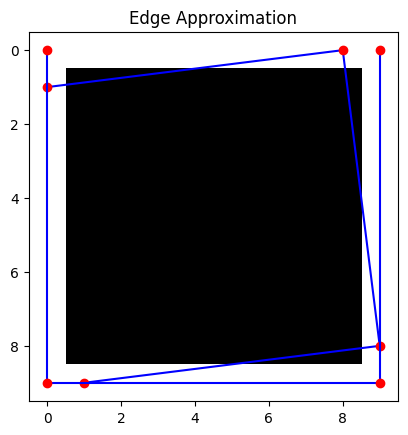

In [7]:
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Führe die Approximation der Kontur durch Geradensegmente durch
# epsilon = 0.02 * cv2.arcLength(contours[0], True)  # Passe den Epsilon-Wert nach Bedarf an

edge_approximations = []

for i in range(len(contours)):
       edge_approx = cv2.approxPolyDP(contours[i], fixed_epsilon, True)
       
       # remove last element if it is already in contour
       # if edge_approx[-1] in edge_approx[:len(edge_approx)-2]:
       #        edge_approx = edge_approx[:-1]
       
       edge_approximations.append(edge_approx)

plot_edge_approx(edge_approximations)

### 2.2 BUG 1 Fixed
---

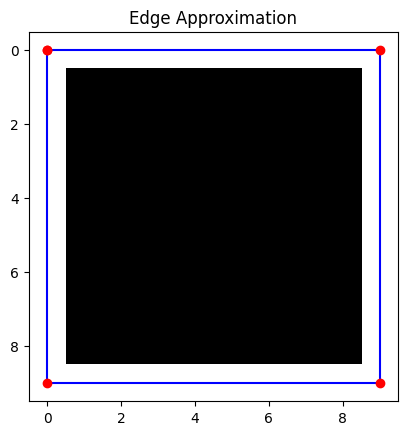

In [8]:
import cv2
import numpy as np

# Finde Konturen im Schwellwertbild
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_segments = []
# Fitting von Geraden durch die Konturen
epsilon = 1.5
for contour in contours:
    # Konturpunkte reduzieren
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    segment = []
    # Segmente hinzufügen
    for i in range(len(approx)):
        if i == 0:
            start_point = approx[i][0]
            segment.append(np.array([start_point]))

        end_point = approx[(i+1) % len(approx)][0]
        segment.append(np.array([end_point]))

    contour_segments.append(np.array(segment))

plot_edge_approx(contour_segments)


## 3. BUG 2: Duplicate Edges
---
**TODO:**
- Finde die Segmente die doppelt/ unnütz sind. 
### 3.1 Problem
---

In [7]:
edges = np.array([
       [255,   0, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)

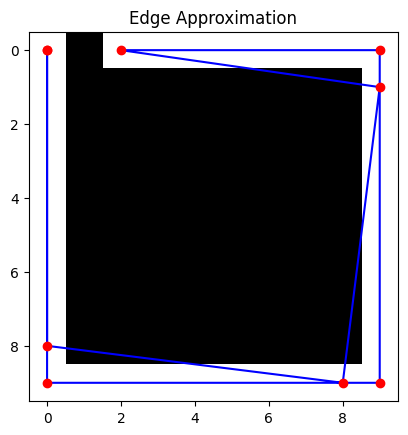

In [8]:
# Finde Konturen im Schwellwertbild
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_segments = []
# Fitting von Geraden durch die Konturen
epsilon = 1.5
for contour in contours:
    # Konturpunkte reduzieren
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    segment = []
    # Segmente hinzufügen
    for i in range(len(approx)):
        if i == 0:
            start_point = approx[i][0]
            segment.append(np.array([start_point]))

        end_point = approx[(i+1) % len(approx)][0]
        segment.append(np.array([end_point]))

    contour_segments.append(np.array(segment))

plot_edge_approx(contour_segments)

### 3.2 Bug2 Fixed
---

In [9]:
def checkIfContourPointInSegment(segmentStart, segmentEnd, contourPoint, epsilon):
    # Calculate the Contour Point on the line with the shortest Distance
    t = np.dot(contourPoint - segmentStart, segmentEnd - segmentStart) / np.linalg.norm(segmentEnd - segmentStart) ** 2
    P = np.round(segmentStart + t * (segmentEnd - segmentStart), decimals=4)

    # Check if P is on the Segment Line
    # pIsInSegmentLine = np.all((P >= s_start) & (P <= s_end)) | np.all((P >= s_end) & (P <= s_start))
    pIsInSegmentLine = np.all(P >= np.minimum(segmentStart, segmentEnd)) and np.all(P <= np.maximum(segmentStart, segmentEnd))
    if pIsInSegmentLine == False:
        return False

    # Calculate the distance between the Contour Point and the line
    distance = np.linalg.norm(P - contourPoint)

    if distance <= epsilon:
        return True
    else: 
        return False

def getContourPointsOfSegment(segmentStart, segmentEnd, contourPoints, epsilon):
    segementContourPoints = []
    for contourPoint in contourPoints:
        if checkIfContourPointInSegment(segmentStart, segmentEnd, contourPoint, epsilon):
            segementContourPoints.append(contourPoint)

    return np.array(segementContourPoints)


def getContourSegments(edge_image, epsilon):
    # Finde Konturen im Schwellwertbild
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contour_segments = []
    # Fitting von Geraden durch die Konturen
    contour_count = len(contours)
    for contour in contours:
        contour_count = contour_count - 1
        print(contour_count)
        # Konturpunkte reduzieren
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Check if These is right
        segment_ended = False

        contour_points = np.array([np.array(cP[0]) for cP in contour])
        rescent_end_point = None
        segment = []
        # Segmente hinzufügen
        for i in range(len(approx)):
            if i == 0:
                start_point = approx[i][0]
                rescent_end_point = start_point
                segment.append(np.array([start_point]))

            end_point = approx[(i+1) % len(approx)][0]

            segementContourPoints = getContourPointsOfSegment(segmentStart=rescent_end_point, 
                                    segmentEnd=end_point, 
                                    contourPoints=contour_points, 
                                    epsilon=epsilon)
            
            # Print Logs
            # print('contour_points', len(contour_points), 'segementContourPoints', len(segementContourPoints))
            # print('start', rescent_end_point, 'end', end_point, 'segementContourPoints', segementContourPoints)
            
            # append Edge to List
            if len(contour_points) != 0:
                if segment_ended:
                    print('error')

                segment.append(np.array([end_point]))
            else:
                segment_ended = True

            # print('segementContourPoints', segementContourPoints)
            # print('contour_points', contour_points)

            # Remove used Contour Points from List
            contour_points = np.array([point for point in contour_points if not np.any(np.all(point == segementContourPoints, axis=1))]) \
                if segementContourPoints.size != 0 \
                else contour_points


            rescent_end_point = end_point

        contour_segments.append(np.array(segment))
    return contour_segments

0


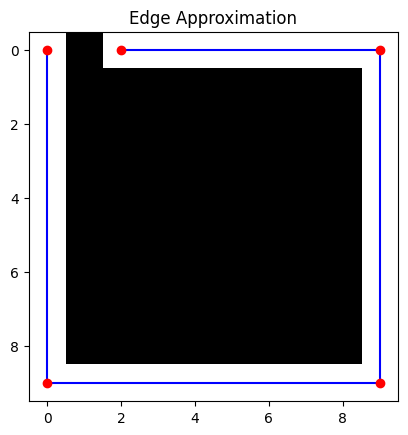

In [10]:
epsilon = 1.5
plot_edge_approx(getContourSegments(edges, epsilon))

## 4. Test Implementation
---
### 4.1 Test 1

0


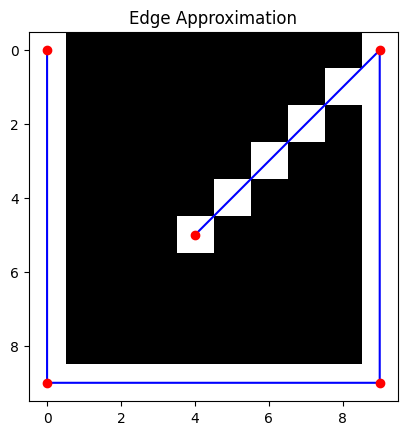

In [11]:
edges = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255,   0,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0,   0,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0,   0,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)

epsilon = 1.5
plot_edge_approx(getContourSegments(edges, epsilon))

### 4.2 Test 2
---

0


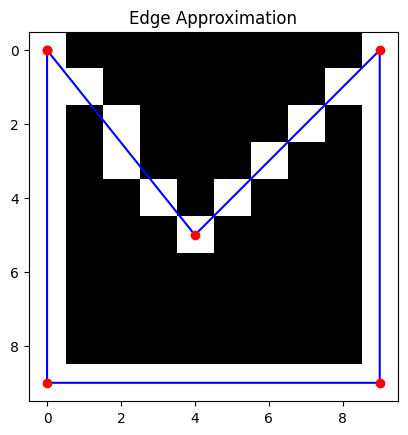

In [12]:
edges = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0, 255, 255],
       [255,   0, 255,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)

epsilon = 1.5
plot_edge_approx(getContourSegments(edges, epsilon))

### 4.3 Test 3
---
- Verwendung von CHAIN_APPROX_NONE löst das Problem

0


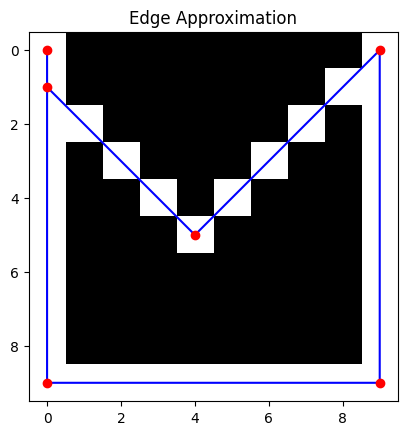

In [13]:
edges = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]).astype(np.uint8)

epsilon = 0.0
plot_edge_approx(getContourSegments(edges, epsilon))

### 4.4 Test 4
---

In [14]:
def plot_edge_approx2(edge_image, edge_approximations):
    # Plot des Edge-Bildes
    plt.imshow(edge_image, cmap='gray')

    # Plot der approximierten Kanten als Linien mit blauer Farbe
    drawn_lines = set()  # Eine Menge zum Speichern der bereits gezeichneten Linien
    for edge_approx in edge_approximations:
        x_approx = edge_approx[:, :, 0].flatten()
        y_approx = edge_approx[:, :, 1].flatten()

        # Überprüfen, ob die Linie bereits gezeichnet wurde
        line = tuple(zip(x_approx, y_approx))
        if line in drawn_lines:
            plt.plot(x_approx, y_approx, color='red')  # Linie in Rot zeichnen
        else:
            plt.plot(x_approx, y_approx, color='blue')

        # Plot der Eckpunkte als rote Punkte
        plt.plot(x_approx, y_approx, 'ro')

        # Füge die Linie zur Menge der bereits gezeichneten Linien hinzu
        drawn_lines.add(line)

    plt.title('Edge Approximation')

    # Anpassung der Achsenskalierung
    plt.axis('scaled')

    # Anzeigen 

0


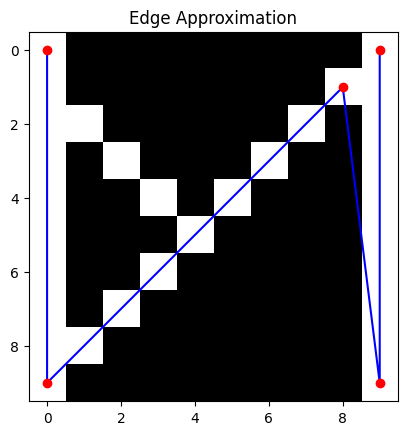

In [15]:
edges = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0, 255,   0,   0,   0,   0,   0, 255],
       [255,   0, 255,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0, 255]]).astype(np.uint8)

epsilon = 2.0
plot_edge_approx2(edges, getContourSegments(edges, epsilon))

In [16]:
slice = np.array([[249, 250, 249, 253, 250, 239, 241, 250, 241, 227],
       [250, 250, 249, 251, 245, 232, 233, 250, 246, 234],
       [250, 250, 243, 238, 228, 215, 230, 243, 242, 234],
       [240, 248, 244, 238, 232, 226, 226, 232, 240, 243],
       [228, 247, 248, 242, 243, 246, 229, 222, 235, 245],
       [225, 246, 246, 236, 237, 244, 240, 219, 224, 231],
       [239, 243, 244, 242, 239, 238, 245, 232, 228, 219],
       [245, 230, 231, 245, 240, 222, 226, 229, 218, 216],
       [248, 230, 225, 242, 250, 241, 221, 227, 219, 218],
       [248, 241, 229, 228, 234, 240, 231, 226, 230, 223]]).astype(np.uint8)

edge_image = cv2.Canny(slice, 50, 150)

0


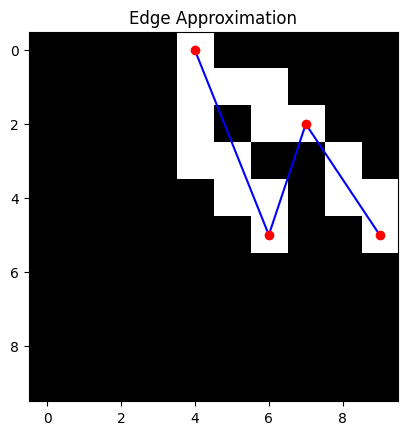

In [17]:
epsilon = 2.0
plot_edge_approx2(edge_image, getContourSegments(edge_image, epsilon))

In [18]:
preloaded_images = None
with open("../../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)
# slice = gray[50:60, 50:60]

In [19]:
epsilon = 2.0
contours = getContourSegments(edge_image, epsilon)

1649
1648
1647
1646
1645
1644
1643
1642
1641
1640
1639
1638
1637
1636
1635
1634
1633
1632
1631
1630
1629


/var/folders/tx/43w7c8cd7g137h5qbd3hr_v00000gn/T/ipykernel_19197/858725739.py:3: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(contourPoint - segmentStart, segmentEnd - segmentStart) / np.linalg.norm(segmentEnd - segmentStart) ** 2


1628
1627
1626
1625
1624
1623
1622
1621
1620
1619
1618
1617
1616
1615
1614
1613
1612
1611
1610
1609
1608
1607
1606
1605
1604
1603
1602
1601
1600
1599
1598
1597
1596
1595
1594
1593
1592
1591
1590
1589
1588
1587
1586
1585
1584
1583
1582
1581
1580
1579
1578
1577
1576
1575
1574
1573
1572
1571
1570
1569
1568
1567
1566
1565
1564
1563
1562
1561
1560
1559
1558
1557
1556
1555
1554
1553
1552
1551
1550
1549
1548
1547
1546
1545
1544
1543
1542
1541
1540
1539
1538
1537
1536
1535
1534
1533
1532
1531
1530
1529
1528
1527
1526
1525
1524
1523
1522
1521
1520
1519
1518
1517
1516
1515
1514
1513
1512
1511
1510
1509
1508
1507
1506
1505
1504
1503
1502
1501
1500
1499
1498
1497
1496
1495
1494
1493
1492
1491
1490
1489
1488
1487
1486
1485
1484
1483
1482
1481
1480
1479
1478
1477
1476
1475
1474
1473
1472
1471
1470
1469
1468
1467
1466
1465
1464
1463
1462
1461
1460
1459
1458
1457
1456
1455
1454
1453
1452
1451
1450
1449
1448
1447
1446
1445
1444
1443
1442
1441
1440
1439
1438
1437
1436
1435
1434
1433
1432
1431
1430
1429


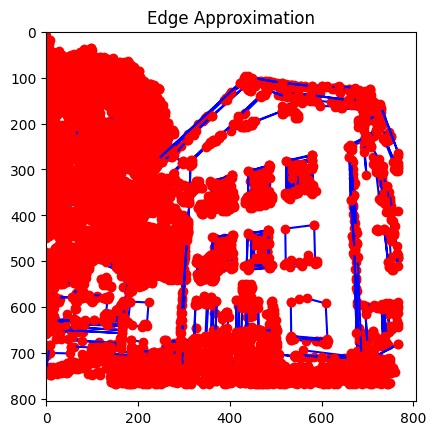

In [20]:
plot_edge_approx(contours)

In [25]:
# Image Preprocessing Params
blurr_kernel_size = 5
risize_factor = 2

# Shortest Path
start_point = np.array([0, 0])

# GCODE Params
z_safe_hight = 10.0
z_working_hight = 0.5
z_zero_height = 0
z_feed_height = -3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000

# Maximaler Vorschub ist ca. 3000 (immer bei G0) (3000mm pro Minute)
g0_feed = 3000


def generateGCODE(contours):
    gcode_lines = []

    # Drehgeschwindigkeit und initiale Höhe festlegen
    gcode_lines += [
        f'M03 S{spindle_speed}', 
        f'G00 Z{z_safe_hight}'
    ]

    # GCODE für die Kontouren
    for i, edge_approx in enumerate(contours):
        gcode_lines += [
            f'######## Contour {i+1} ########',
            f'G00 X{edge_approx[0][0][0]} Y{edge_approx[0][0][1]}',
            # f'G00 Z{z_working_hight}' if i == 0 else None,
            f'G00 Z{z_zero_height}',
            f'G01 Z{z_feed_height} F{z_feed}',
            f'G01 X{edge_approx[1][0][0]} Y{edge_approx[1][0][1]} F{xy_feed}' if len(edge_approx) > 1 else None,
            *[f'G01 X{edge[0][0]} Y{edge[0][1]}' for edge in edge_approx[2:]],
            f'G00 Z{z_working_hight}'
        ]

    # Fräßkopf zu initialer Position zurückbewegen
    gcode_lines += [
        '######## End ########',
        f'G00 Z{z_safe_hight}',
        'G00 X0 Y0',
        'M05',
        'M30'
    ]

    # None Elemente entfernen und GCODE erstellen
    gcode = '\n'.join([line for line in gcode_lines if line != None])

    return gcode_lines

    # # Save the G-code to a file
    # with open('gcode.tap', "w") as f:
    #     f.writelines(gcode)

    # # Print GCODE Stats
    # print('\n'.join([
    #     'Generated GCODE',
    #     f'Amount of Contours: {len(contours)}',
    #     f'Amount of Lines: {len(gcode_lines)}',
    # ]))

def calculate_g0_distance(contours):
    total_distance = 0
    start_end_point = np.array([0, 0])
    recent_contour_end = start_end_point

    for contour in contours:
        contour_points = contour.squeeze()
        start = contour_points[0] # set startPoint of Contour
        total_distance += np.linalg.norm(start - recent_contour_end)  # Calc euklidian dinstance
        recent_contour_end = contour_points[-1] # set endPoint of Contour

    total_distance += np.linalg.norm(np.array([0, 0]) - recent_contour_end)

    return total_distance

def calculate_g1_distance(contours):
    total_distance = 0

    for contour in contours:
        contour = contour.squeeze()
        recent_point = contour[0]

        for point in contour[1:]:
            total_distance += np.linalg.norm(recent_point - point)
            recent_point = point

    return total_distance

def calculate_z_distance(contours):
    g0_z_distance = z_safe_hight - z_working_hight + (z_working_hight - z_zero_height) * 2 * len(contours)
    g1_z_distance = (z_zero_height - z_feed_height) * len(contours)

    return g0_z_distance, g1_z_distance

def convert_minutes_to_time(minutes):
    total_time_seconds = int((minutes) * 60)
    total_time_hours = total_time_seconds // 3600
    remaining_seconds = total_time_seconds % 3600
    total_time_minutes = remaining_seconds // 60
    remaining_seconds = remaining_seconds % 60

    return f'{total_time_hours:02d}:{total_time_minutes:02d}:{remaining_seconds:02d}'

def calculate_gcode_stats(contours, gcode):
    g0_xy_distance = calculate_g0_distance(contours)
    g1_xy_distance = calculate_g1_distance(contours)
    g0_z_distance, g1_z_distance = calculate_z_distance(contours)

    total_feeding_time = (g0_xy_distance / g0_feed) + (g1_xy_distance / xy_feed) + (g0_z_distance / g0_feed) + (g1_z_distance / z_feed)
    g0_feeding_time = (g0_xy_distance / g0_feed) + (g0_z_distance / g0_feed)
    g1_feeding_time = (g1_xy_distance / xy_feed) + (g1_z_distance / z_feed)

    return {
        'total_feeding_time': convert_minutes_to_time(total_feeding_time),
        'amt_contours': len(contours),
        'amt_gcode_lines': len(gcode),
        'g0_xy_distance': g0_xy_distance,
        'g0_z_distance': g0_z_distance,
        'g0_feeding_time': convert_minutes_to_time(g0_feeding_time),
        'g1_xy_distance': g1_xy_distance,
        'g1_z_distance': g1_z_distance,
        'g1_feeding_time': convert_minutes_to_time(g1_feeding_time)
    }

In [26]:
gcode = generateGCODE(contours)

In [28]:
calculate_gcode_stats(contours, gcode)

{'total_feeding_time': None,
 'amt_contours': 1650,
 'amt_gcode_lines': 19075,
 'g0_xy_distance': 268814.4701590117,
 'g0_z_distance': 1659.5,
 'g0_feeding_time': None,
 'g1_xy_distance': 88810.63118689627,
 'g1_z_distance': 4950,
 'g1_feeding_time': None}